# Bert 

In [5]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import os

# Ensure GPU is used if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create directory for saving results
os.makedirs("visualization", exist_ok=True)


## Step 1: Data Loading

In [6]:
# Define NSL-KDD column names
c_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels", "difficulty_degree"
]

# Load dataset
train_df = pd.read_csv("data/KDDTrain+.txt", names=c_names)
test_df = pd.read_csv("data/KDDTest+.txt", names=c_names)

# Drop difficulty degree column (not needed)
train_df.drop("difficulty_degree", axis=1, inplace=True)
test_df.drop("difficulty_degree", axis=1, inplace=True)

# Convert categorical features to string representation
categorical_features = ["protocol_type", "service", "flag"]
for col in categorical_features:
    train_df[col] = train_df[col].astype(str)
    test_df[col] = test_df[col].astype(str)

# Convert labels into binary classification
train_df["labels"] = train_df["labels"].apply(lambda x: 1 if x == "normal" else 0)
test_df["labels"] = test_df["labels"].apply(lambda x: 1 if x == "normal" else 0)


In [7]:
# First, split train data into train/validation (STRATIFIED SPLIT to maintain class balance)
train_df, val_df = train_test_split(
    train_df, test_size=0.2, random_state=42, stratify=train_df["labels"]
)

# Function to convert tabular data into text for NLP processing
def convert_to_text(row):
    return f"Duration: {row['duration']}, Protocol: {row['protocol_type']}, " \
           f"Service: {row['service']}, Flag: {row['flag']}, " \
           f"Src_Bytes: {row['src_bytes']}, Dst_Bytes: {row['dst_bytes']}, " \
           f"Count: {row['count']}, Serror_Rate: {row['serror_rate']}"

# Apply text conversion AFTER splitting
train_df["text_features"] = train_df.apply(convert_to_text, axis=1)
val_df["text_features"] = val_df.apply(convert_to_text, axis=1)
test_df["text_features"] = test_df.apply(convert_to_text, axis=1)


In [12]:
from sklearn.preprocessing import LabelEncoder

# List of categorical columns
categorical_features = ["protocol_type", "service", "flag"]

# Apply Label Encoding to categorical variables
label_encoders = {}  # Store encoders for future transformations
for col in categorical_features:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])  # Fit on training data
    val_df[col] = le.transform(val_df[col])  # Transform validation set
    test_df[col] = le.transform(test_df[col])  # Transform test set
    label_encoders[col] = le  # Store encoder for inverse transformation if needed


In [14]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE (excluding 'text_features' which is for BERT)
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(
    train_df.drop(columns=["labels", "text_features"]),  # Only numeric features
    train_df["labels"]
)

# Convert back to DataFrame
train_df = pd.DataFrame(X_resampled, columns=train_df.drop(columns=["labels", "text_features"]).columns)
train_df["labels"] = y_resampled  # Restore labels

# Recreate text features for BERT processing
train_df["text_features"] = train_df.apply(convert_to_text, axis=1)


In [15]:
df_majority = train_df[train_df["labels"] == 1]  # Normal traffic
df_minority = train_df[train_df["labels"] == 0]  # Attack traffic

df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42)
train_df = pd.concat([df_majority_downsampled, df_minority])


In [16]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Convert data to Hugging Face Dataset
train_data = Dataset.from_dict({"text": train_df["text_features"].tolist(), "label": train_df["labels"].tolist()})
val_data = Dataset.from_dict({"text": val_df["text_features"].tolist(), "label": val_df["labels"].tolist()})
test_data = Dataset.from_dict({"text": test_df["text_features"].tolist(), "label": test_df["labels"].tolist()})

# Apply tokenization
train_data = train_data.map(tokenize_function, batched=True)
val_data = val_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)


Map: 100%|██████████| 22544/22544 [00:05<00:00, 3953.69 examples/s]


In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
).to(device)

training_args = TrainingArguments(
    output_dir="./bert_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_149622/2272630366.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
                                                     
  2%|▏         | 438/17589 [07:49<1:28:38,  3.22it/s]

{'loss': 0.3789, 'grad_norm': 55.6065788269043, 'learning_rate': 9.718574108818012e-06, 'epoch': 0.09}


                                                     
  2%|▏         | 438/17589 [10:22<1:28:38,  3.22it/s] 

{'loss': 0.1779, 'grad_norm': 0.23574458062648773, 'learning_rate': 9.434305531866508e-06, 'epoch': 0.17}


                                                     
  2%|▏         | 438/17589 [13:00<1:28:38,  3.22it/s] 

{'loss': 0.1375, 'grad_norm': 0.0932445228099823, 'learning_rate': 9.15117402922281e-06, 'epoch': 0.26}


                                                     
  2%|▏         | 438/17589 [15:39<1:28:38,  3.22it/s] 

{'loss': 0.0993, 'grad_norm': 0.17871606349945068, 'learning_rate': 8.866905452271308e-06, 'epoch': 0.34}


                                                     
  2%|▏         | 438/17589 [18:13<1:28:38,  3.22it/s] 

{'loss': 0.1006, 'grad_norm': 0.11832572519779205, 'learning_rate': 8.582636875319804e-06, 'epoch': 0.43}


                                                     
  2%|▏         | 438/17589 [20:44<1:28:38,  3.22it/s] 

{'loss': 0.0732, 'grad_norm': 21.953704833984375, 'learning_rate': 8.298368298368298e-06, 'epoch': 0.51}


                                                     
  2%|▏         | 438/17589 [23:14<1:28:38,  3.22it/s] 

{'loss': 0.0686, 'grad_norm': 0.03591058403253555, 'learning_rate': 8.014099721416795e-06, 'epoch': 0.6}


                                                     
  2%|▏         | 438/17589 [25:45<1:28:38,  3.22it/s] 

{'loss': 0.0551, 'grad_norm': 0.044476356357336044, 'learning_rate': 7.729831144465293e-06, 'epoch': 0.68}


                                                     
  2%|▏         | 438/17589 [28:15<1:28:38,  3.22it/s] 

{'loss': 0.0601, 'grad_norm': 0.03719954565167427, 'learning_rate': 7.4461311046676906e-06, 'epoch': 0.77}


                                                     
  2%|▏         | 438/17589 [30:45<1:28:38,  3.22it/s] 

{'loss': 0.0476, 'grad_norm': 1.3127872943878174, 'learning_rate': 7.161862527716187e-06, 'epoch': 0.85}


                                                     
  2%|▏         | 438/17589 [33:16<1:28:38,  3.22it/s] 

{'loss': 0.042, 'grad_norm': 0.018279168754816055, 'learning_rate': 6.877593950764683e-06, 'epoch': 0.94}


{'eval_loss': 1.5924286842346191, 'eval_runtime': 135.2243, 'eval_samples_per_second': 186.32, 'eval_steps_per_second': 46.582, 'epoch': 1.0}


                                                     
  2%|▏         | 438/17589 [38:03<1:28:38,  3.22it/s]

{'loss': 0.0483, 'grad_norm': 0.05463327094912529, 'learning_rate': 6.59332537381318e-06, 'epoch': 1.02}


                                                     
  2%|▏         | 438/17589 [40:37<1:28:38,  3.22it/s]

{'loss': 0.0436, 'grad_norm': 23.581850051879883, 'learning_rate': 6.309625334015579e-06, 'epoch': 1.11}


                                                     
  2%|▏         | 438/17589 [43:09<1:28:38,  3.22it/s]

{'loss': 0.0385, 'grad_norm': 0.1258206069469452, 'learning_rate': 6.025356757064074e-06, 'epoch': 1.19}


                                                     
  2%|▏         | 438/17589 [45:40<1:28:38,  3.22it/s]

{'loss': 0.0375, 'grad_norm': 0.019270576536655426, 'learning_rate': 5.7410881801125705e-06, 'epoch': 1.28}


                                                     
  2%|▏         | 438/17589 [48:11<1:28:38,  3.22it/s]

{'loss': 0.0369, 'grad_norm': 0.009230847470462322, 'learning_rate': 5.456819603161067e-06, 'epoch': 1.36}


                                                     
  2%|▏         | 438/17589 [50:42<1:28:38,  3.22it/s]

{'loss': 0.0307, 'grad_norm': 82.75785064697266, 'learning_rate': 5.172551026209564e-06, 'epoch': 1.45}


                                                     
  2%|▏         | 438/17589 [53:13<1:28:38,  3.22it/s]

{'loss': 0.0314, 'grad_norm': 0.04835059493780136, 'learning_rate': 4.889419523565865e-06, 'epoch': 1.54}


                                                     
  2%|▏         | 438/17589 [55:44<1:28:38,  3.22it/s]

{'loss': 0.0348, 'grad_norm': 13.190858840942383, 'learning_rate': 4.605150946614362e-06, 'epoch': 1.62}


                                                     
  2%|▏         | 438/17589 [1:00:59<1:28:38,  3.22it/s]

{'loss': 0.0251, 'grad_norm': 0.06351961195468903, 'learning_rate': 4.320882369662858e-06, 'epoch': 1.71}


                                                       
  2%|▏         | 438/17589 [1:06:20<1:28:38,  3.22it/s]  

{'loss': 0.0304, 'grad_norm': 0.03527892380952835, 'learning_rate': 4.036613792711354e-06, 'epoch': 1.79}


                                                       
  2%|▏         | 438/17589 [1:11:40<1:28:38,  3.22it/s]  

{'loss': 0.0308, 'grad_norm': 0.006562329828739166, 'learning_rate': 3.75234521575985e-06, 'epoch': 1.88}


                                                       
  2%|▏         | 438/17589 [1:17:01<1:28:38,  3.22it/s]  

{'loss': 0.0362, 'grad_norm': 0.007238784339278936, 'learning_rate': 3.4680766388083465e-06, 'epoch': 1.96}


{'eval_loss': 2.2906455993652344, 'eval_runtime': 290.6744, 'eval_samples_per_second': 86.678, 'eval_steps_per_second': 21.67, 'epoch': 2.0}


                                                       
  2%|▏         | 438/17589 [1:27:13<1:28:38,  3.22it/s]

{'loss': 0.0189, 'grad_norm': 0.01682543009519577, 'learning_rate': 3.1838080618568427e-06, 'epoch': 2.05}


                                                       
  2%|▏         | 438/17589 [1:32:34<1:28:38,  3.22it/s]

{'loss': 0.0209, 'grad_norm': 0.003541909856721759, 'learning_rate': 2.899539484905339e-06, 'epoch': 2.13}


                                                       
  2%|▏         | 438/17589 [1:37:55<1:28:38,  3.22it/s]

{'loss': 0.0244, 'grad_norm': 0.013837948441505432, 'learning_rate': 2.615270907953835e-06, 'epoch': 2.22}


                                                       
  2%|▏         | 438/17589 [1:43:15<1:28:38,  3.22it/s]

{'loss': 0.0206, 'grad_norm': 0.006003151182085276, 'learning_rate': 2.331002331002331e-06, 'epoch': 2.3}


                                                       
  2%|▏         | 438/17589 [1:48:36<1:28:38,  3.22it/s]

{'loss': 0.0315, 'grad_norm': 0.023388555273413658, 'learning_rate': 2.0467337540508276e-06, 'epoch': 2.39}


                                                       
  2%|▏         | 438/17589 [1:53:56<1:28:38,  3.22it/s]

{'loss': 0.0229, 'grad_norm': 0.00881702546030283, 'learning_rate': 1.7624651770993238e-06, 'epoch': 2.47}


                                                       
  2%|▏         | 438/17589 [1:59:17<1:28:38,  3.22it/s]

{'loss': 0.0343, 'grad_norm': 25.60178565979004, 'learning_rate': 1.4781966001478198e-06, 'epoch': 2.56}


                                                       
  2%|▏         | 438/17589 [2:04:37<1:28:38,  3.22it/s]

{'loss': 0.0256, 'grad_norm': 0.007112941704690456, 'learning_rate': 1.193928023196316e-06, 'epoch': 2.64}


                                                       
  2%|▏         | 438/17589 [2:09:58<1:28:38,  3.22it/s]

{'loss': 0.0247, 'grad_norm': 0.008081557229161263, 'learning_rate': 9.096594462448122e-07, 'epoch': 2.73}


                                                       
  2%|▏         | 438/17589 [2:15:19<1:28:38,  3.22it/s]

{'loss': 0.018, 'grad_norm': 0.01078026182949543, 'learning_rate': 6.253908692933083e-07, 'epoch': 2.81}


                                                       
  2%|▏         | 438/17589 [2:20:40<1:28:38,  3.22it/s]

{'loss': 0.018, 'grad_norm': 0.004157852381467819, 'learning_rate': 3.4169082949570753e-07, 'epoch': 2.9}


                                                       
  2%|▏         | 438/17589 [2:26:00<1:28:38,  3.22it/s]

{'loss': 0.0202, 'grad_norm': 0.02116233855485916, 'learning_rate': 5.742225254420377e-08, 'epoch': 2.98}


{'eval_loss': 1.448043704032898, 'eval_runtime': 290.5555, 'eval_samples_per_second': 86.713, 'eval_steps_per_second': 21.679, 'epoch': 3.0}


                                                       
100%|██████████| 17589/17589 [2:26:32<00:00,  2.00it/s]

{'train_runtime': 8792.3997, 'train_samples_per_second': 32.008, 'train_steps_per_second': 2.0, 'train_loss': 0.05536914649821106, 'epoch': 3.0}


TrainOutput(global_step=17589, training_loss=0.05536914649821106, metrics={'train_runtime': 8792.3997, 'train_samples_per_second': 32.008, 'train_steps_per_second': 2.0, 'total_flos': 7.404576564363264e+16, 'train_loss': 0.05536914649821106, 'epoch': 3.0})

In [26]:
preds = trainer.predict(val_data)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = val_df["labels"].tolist()

probs = softmax(preds.predictions, axis=1)[:, 1]
fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)


100%|██████████| 6299/6299 [05:03<00:00, 20.79it/s]


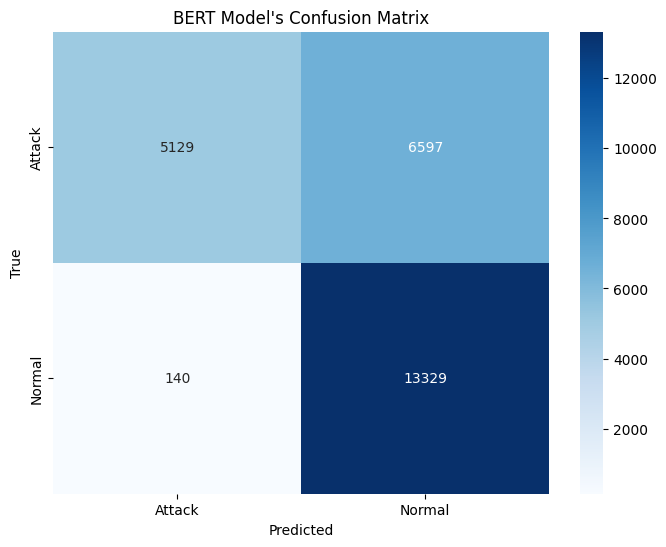

In [32]:
# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("BERT Model's Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("visualization/Bert_confusion_matrix.png")
plt.show()

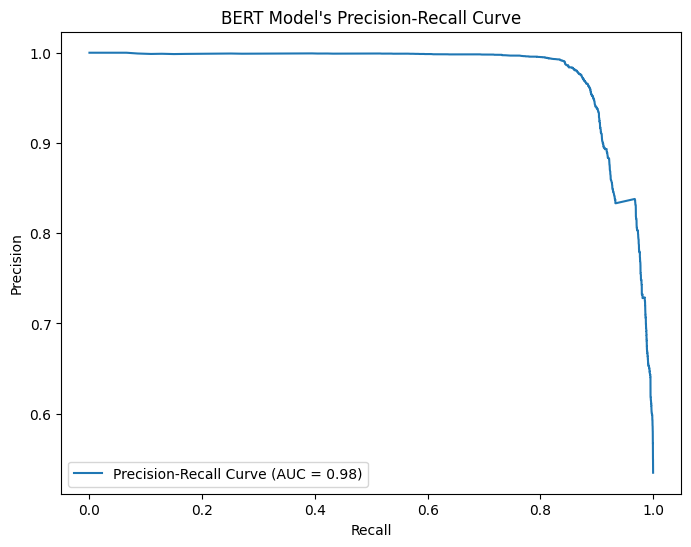

In [29]:
from sklearn.metrics import precision_recall_curve, auc

# Compute Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, probs)
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"Precision-Recall Curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("BERT Model's Precision-Recall Curve")
plt.legend()
plt.savefig("visualization/Bert_precision_recall_curve.png")  # Save to folder
plt.show()


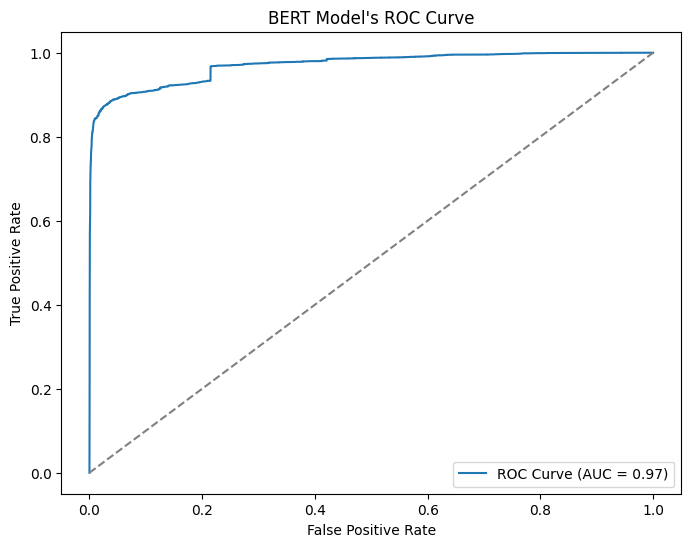

In [30]:
from sklearn.metrics import roc_curve, auc

# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("BERT Model's ROC Curve")
plt.legend()
plt.savefig("visualization/Bert1_roc_curve.png")  # Save to folder
plt.show()


In [25]:
from sklearn.metrics import classification_report

# Generate Classification Report
classification_report_text = classification_report(y_true, y_pred)

# Save to a text file
with open("visualization/Bert-classification_report.txt", "w") as f:
    f.write(classification_report_text)

# Print report
print(classification_report_text)


              precision    recall  f1-score   support

           0       0.97      0.44      0.60     11726
           1       0.67      0.99      0.80     13469

    accuracy                           0.73     25195
   macro avg       0.82      0.71      0.70     25195
weighted avg       0.81      0.73      0.71     25195

